In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')


In [152]:
df1 = pd.read_csv('AutoSleep-20200124-to-20231109.csv')
df2 = pd.read_csv('AutoSleep-20231018-to-20240415.csv')

# Convert 'fromDate' to datetime
# df1['fromDate'] = pd.to_datetime(df1['fromDate'])
# df2['fromDate'] = pd.to_datetime(df2['fromDate'])

# Filter out rows from df2 that are already in df1
df2 = df2[~df2['fromDate'].isin(df1['fromDate'])]

# Concatenate the DataFrames
df = pd.concat([df1, df2])

In [153]:
df = df.drop(['fellAsleepIn', 'SpO2Avg', 'SpO2Min', 'SpO2Max', 'respAvg', 'respMin', 'respMax',
              'tags', 'notes', 'asleepAvg7', 'efficiencyAvg7', 'qualityAvg7', 'deepAvg7', 'sleepBPMAvg7', 
              'dayBPMAvg7', 'wakingBPMAvg7', 'hrvAvg7','sleepHRVAvg7'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 140
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ISO8601     1296 non-null   object 
 1   fromDate    1296 non-null   object 
 2   toDate      1296 non-null   object 
 3   bedtime     1296 non-null   object 
 4   waketime    1296 non-null   object 
 5   inBed       1296 non-null   object 
 6   awake       1296 non-null   object 
 7   sessions    1296 non-null   int64  
 8   asleep      1296 non-null   object 
 9   efficiency  1296 non-null   float64
 10  quality     1295 non-null   object 
 11  deep        1295 non-null   object 
 12  sleepBPM    1295 non-null   float64
 13  dayBPM      1130 non-null   float64
 14  wakingBPM   1294 non-null   float64
 15  hrv         1293 non-null   float64
 16  sleepHRV    1289 non-null   float64
dtypes: float64(6), int64(1), object(10)
memory usage: 182.2+ KB


In [154]:
# Datetime conversions
df['ISO8601'] = pd.to_datetime(df['ISO8601'])
df['fromDate'] = pd.to_datetime(df['fromDate'], format='%A, %b %d, %Y')
df['toDate'] = pd.to_datetime(df['toDate'], format='%A, %b %d, %Y')
df['bedtime'] = pd.to_datetime(df['bedtime']).dt.time
df['waketime'] = pd.to_datetime(df['waketime']).dt.time

df['inBed'] = pd.to_datetime(df['inBed'], format='%H:%M:%S').dt.hour + (pd.to_datetime(df['inBed'], format='%H:%M:%S').dt.minute / 60)
df['awake'] = pd.to_datetime(df['awake'], format='%H:%M:%S').dt.hour  + (pd.to_datetime(df['awake'], format='%H:%M:%S').dt.minute / 60)
df['asleep'] = pd.to_datetime(df['asleep'], format='%H:%M:%S').dt.hour  + (pd.to_datetime(df['asleep'], format='%H:%M:%S').dt.minute / 60)
df['quality'] = pd.to_datetime(df['quality'], format='%H:%M:%S').dt.hour  + (pd.to_datetime(df['quality'], format='%H:%M:%S').dt.minute / 60)
df['deep'] = pd.to_datetime(df['deep'], format='%H:%M:%S').dt.hour  + (pd.to_datetime(df['deep'], format='%H:%M:%S').dt.minute / 60)


In [155]:
# Count how many days since the date of the first record in df until today
daysPassed = (df['fromDate'].max() - df['fromDate'].min()).days

# Find the percentage of days tracked
percentage_tracked = round((len(df) / daysPassed) * 100,2)

from datetime import datetime
from dateutil.relativedelta import relativedelta

timeElapsed = relativedelta(df['fromDate'].max(), df['fromDate'].min())
timeElapsed = f"{timeElapsed.years} years, {timeElapsed.months} months, {timeElapsed.days} days"

monthsMissed = (daysPassed - len(df)) // 30
daysMissed = (daysPassed - len(df)) % 30

print(f"Percentage of days tracked: {percentage_tracked}%")
print(f'Time Elapsed: {timeElapsed}')
print(f'Time Missed: {monthsMissed} months, {daysMissed} days')


Percentage of days tracked: 83.99%
Time Elapsed: 4 years, 2 months, 22 days
Time Missed: 8 months, 7 days


In [156]:
# Rolling values
cols_to_roll = ['asleep', 'quality', 'deep', 'efficiency', 'sleepBPM', 'wakingBPM', 'hrv', 'sleepHRV']
periods = [7,15,30,90]

for col in cols_to_roll:
    for period in periods:
        df[f'{col}Roll{period}'] = df[col].rolling(window=period).mean()


In [164]:
df['qual/asleep'] = df['quality'] / df['asleep']
df['deep/asleep'] = df['deep'] / df['asleep']

In [165]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
inBed,1296.0,8.046425,1.505023,0.600000,7.216667,7.983333,8.804167,23.583333
awake,1296.0,0.797467,0.803546,0.000000,0.200000,0.566667,1.133333,5.316667
sessions,1296.0,1.030093,0.175368,1.000000,1.000000,1.000000,1.000000,3.000000
asleep,1296.0,7.248958,1.439151,0.500000,6.416667,7.283333,8.083333,21.966667
efficiency,1296.0,90.303318,9.273927,22.900000,85.600000,92.900000,97.400000,100.000000
quality,1295.0,5.130631,1.158813,0.166667,4.433333,5.166667,5.883333,14.716667
deep,1295.0,1.870515,0.986767,0.000000,1.266667,1.916667,2.516667,6.733333
sleepBPM,1295.0,55.026486,7.985203,42.000000,49.700000,52.700000,57.850000,103.100000
dayBPM,1130.0,69.449646,9.614396,45.800000,62.825000,69.250000,75.600000,101.800000
wakingBPM,1294.0,50.434621,6.320022,36.000000,47.000000,49.000000,53.000000,117.000000


In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 140
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ISO8601           1296 non-null   object        
 1   fromDate          1296 non-null   datetime64[ns]
 2   toDate            1296 non-null   datetime64[ns]
 3   bedtime           1296 non-null   object        
 4   waketime          1296 non-null   object        
 5   inBed             1296 non-null   float64       
 6   awake             1296 non-null   float64       
 7   sessions          1296 non-null   int64         
 8   asleep            1296 non-null   float64       
 9   efficiency        1296 non-null   float64       
 10  quality           1295 non-null   float64       
 11  deep              1295 non-null   float64       
 12  sleepBPM          1295 non-null   float64       
 13  dayBPM            1130 non-null   float64       
 14  wakingBPM         1294 no

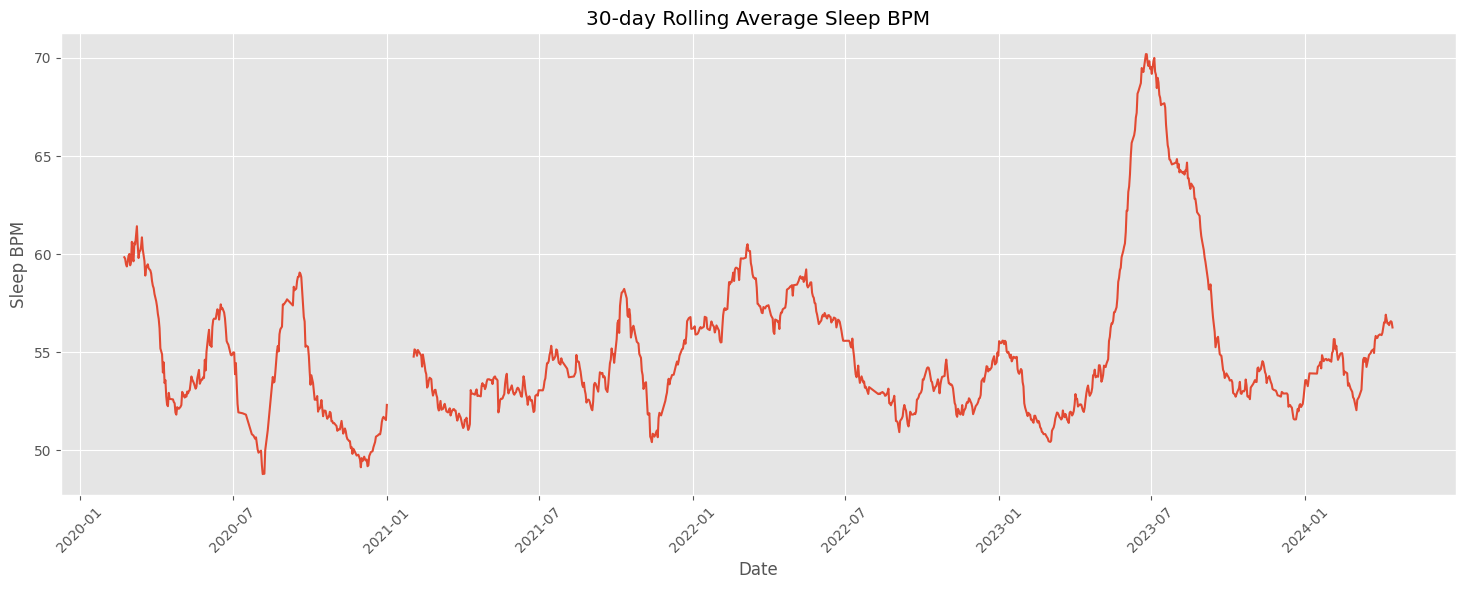

In [159]:
period = 30

plt.figure(figsize=(18,6))
plt.plot(df['fromDate'], df[f'sleepBPMRoll{period}'])
plt.title(f'{period}-day Rolling Average Sleep BPM')
plt.xlabel('Date')
plt.ylabel('Sleep BPM')
plt.xticks(rotation=45)
plt.show()


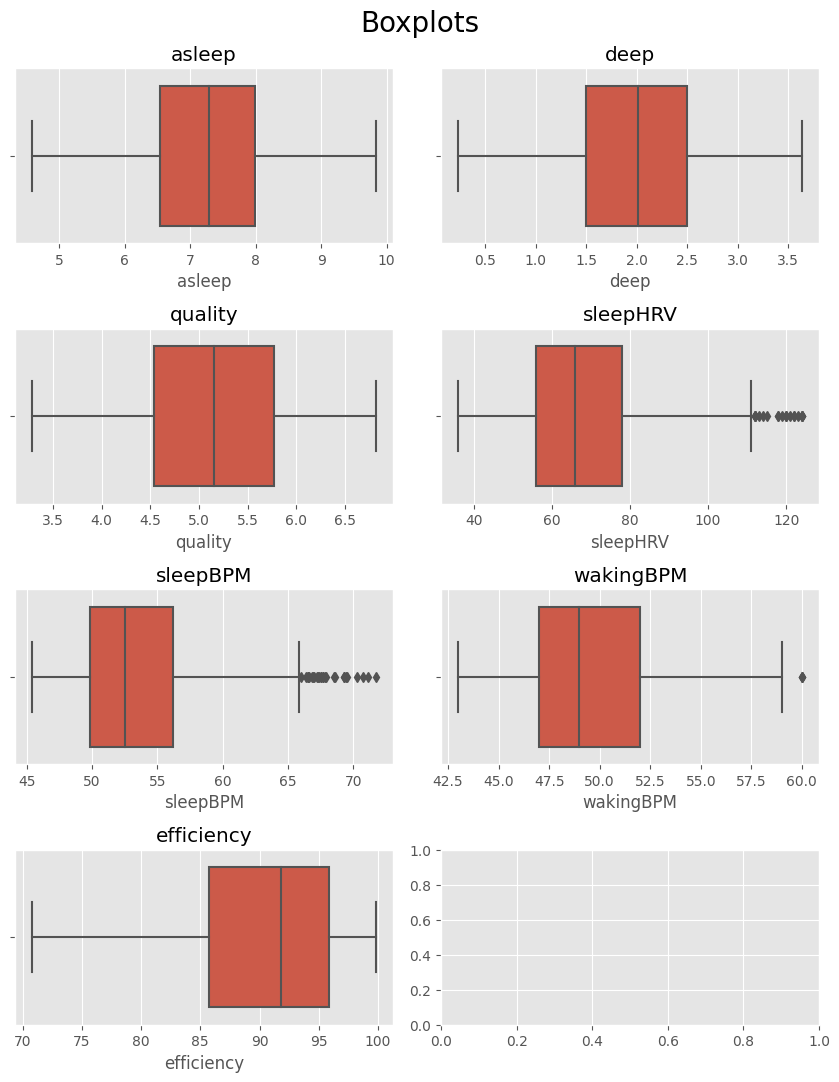

In [163]:
# Remove top and bottom 3 outlier rows for each column
df_box = df[['asleep', 'deep', 'quality', 'sleepHRV', 'sleepBPM', 'wakingBPM', 'efficiency']]
for col in df_box.columns:
    df_box = df_box[(df_box[col] > df_box[col].quantile(0.025)) & (df_box[col] < df_box[col].quantile(0.975))]

# Boxplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8.5, 11))
plt.suptitle('Boxplots', size=20)
for i, col in enumerate(df_box.columns):
    sns.boxplot(x=col, data=df_box, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{col}')
plt.tight_layout()
plt.show()


/var/folders/y_/8cmvsg791ys9qqbzj_yxrlj40000gn/T/ipykernel_69392/2486680100.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = round(df[[col for col in df.columns if 'Roll' not in col and '/' not in col]].corr(),4)


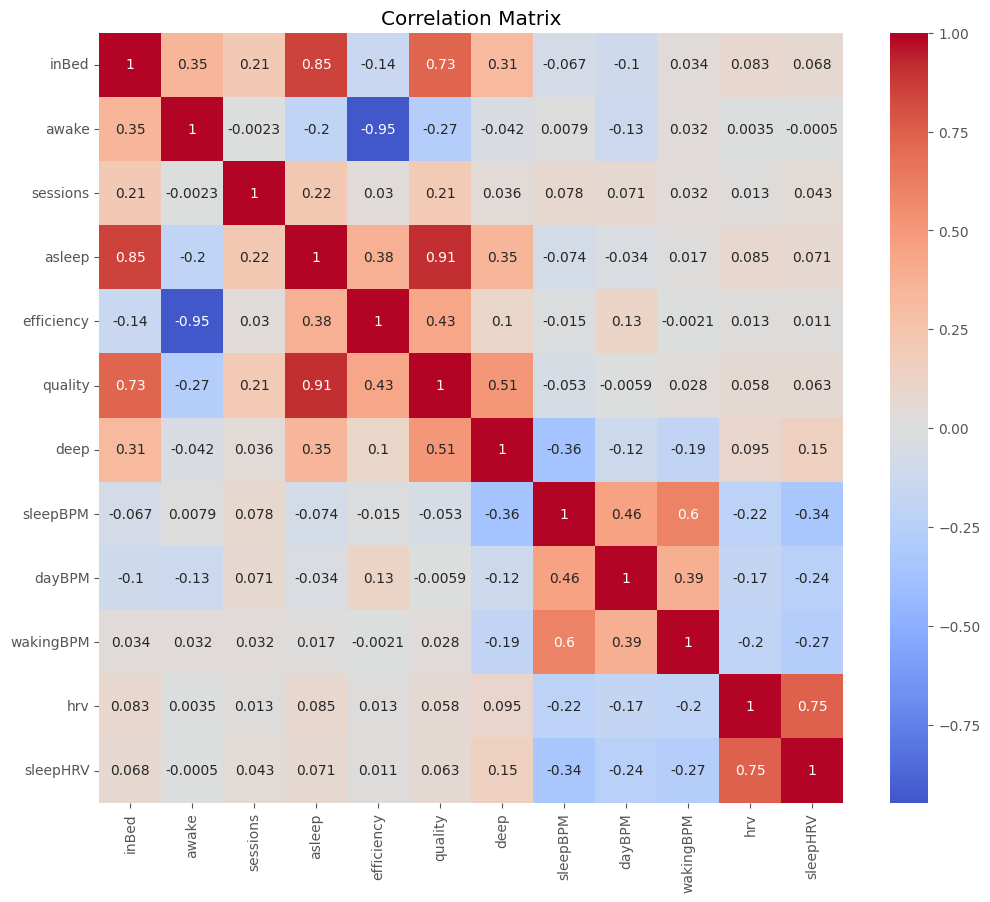

In [184]:
correlation_matrix = round(df[[col for col in df.columns if 'Roll' not in col and '/' not in col]].corr(),4)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


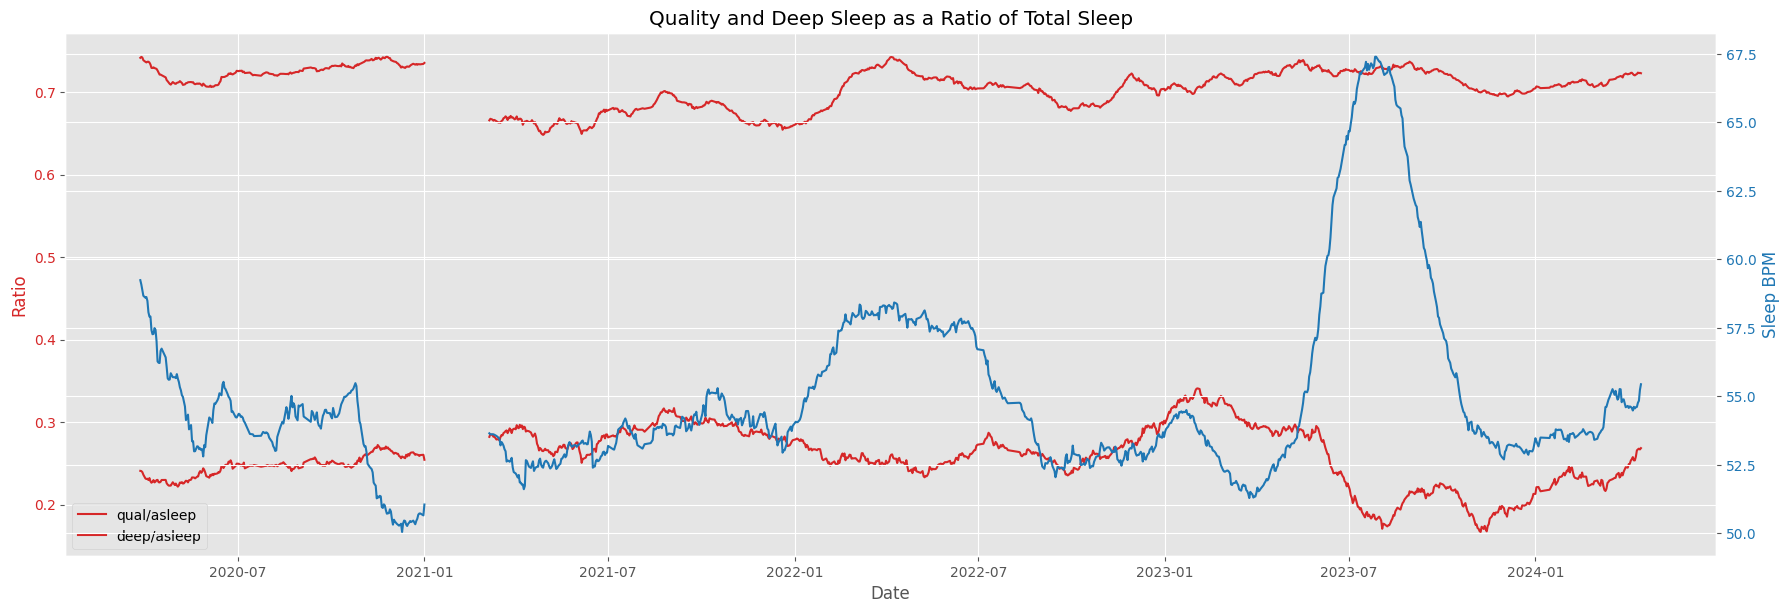

In [178]:
window = 60

fig, ax1 = plt.subplots(figsize=(18,6))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Ratio', color=color)
ax1.plot(df['fromDate'], df['qual/asleep'].rolling(window=window).mean(), label='qual/asleep', color=color)
ax1.plot(df['fromDate'], df['deep/asleep'].rolling(window=window).mean(), label='deep/asleep', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Sleep BPM', color=color)  
ax2.plot(df['fromDate'], df[f'sleepBPM'].rolling(window=window).mean(), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Quality and Deep Sleep as a Ratio of Total Sleep')
plt.xticks(rotation=45)
plt.show()


In [173]:
df[df['deepRoll30'] == df['deepRoll30'].min()]


,ISO8601,fromDate,toDate,bedtime,waketime,inBed,awake,sessions,asleep,efficiency,...,hrvRoll7,hrvRoll15,hrvRoll30,hrvRoll90,sleepHRVRoll7,sleepHRVRoll15,sleepHRVRoll30,sleepHRVRoll90,qual/asleep,deep/asleep
1067,2023-07-06 20:59:59-04:00,2023-07-05,2023-07-06,18:24:00,03:26:00,9.033333,0.0,1,9.033333,100.0,...,66.714286,64.2,71.0,NaN,56.285714,56.333333,NaN,NaN,0.710332,0.027675
